In [ ]:
%matplotlib inline

from google.colab import drive

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import load_model
import os
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight
from sklearn.preprocessing import label_binarize


drive.mount('/content/drive')
DATASET_PATH = "..."

Mounted at /content/drive


In [2]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    seed=85,

    shuffle=True,

    image_size=(224, 224),

    batch_size=32
)

Found 1266 files belonging to 2 classes.


In [3]:
bean_classes = dataset.class_names
bean_classes

['healthy', 'unhealthy']

In [5]:

len(dataset)

40

In [ ]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    dataset_size = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=85)

    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)

    train_set = dataset.take(train_size)
    val_set = dataset.skip(train_size).take(val_size)
    test_set = dataset.skip(train_size).skip(val_size)

    return train_set, val_set, test_set

In [6]:
train_set, val_set, test_set = get_dataset_partitions_tf(dataset)

In [7]:

len(train_set), len(val_set), len(test_set)

(32, 4, 4)

In [8]:
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(224, 224),
  tf.keras.layers.Rescaling(1.0/255),
])

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.5621 - loss: 0.8884 - val_accuracy: 0.7422 - val_loss: 0.5363
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.7900 - loss: 0.4932 - val_accuracy: 0.7500 - val_loss: 0.4987
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.8015 - loss: 0.4459 - val_accuracy: 0.7969 - val_loss: 0.5013
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.8519 - loss: 0.4042 - val_accuracy: 0.6797 - val_loss: 0.6145
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8144 - loss: 0.4034 - val_accuracy: 0.7734 - val_loss: 0.4888
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8416 - loss: 0.4183 - val_accuracy: 0.7891 - val_loss: 0.4904
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.8512 - loss: 0.3406 - val_accuracy: 0.7969 - val_loss: 0.4737
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.8389 - loss: 0.3678 - val_accuracy: 0.7969 - val_loss:

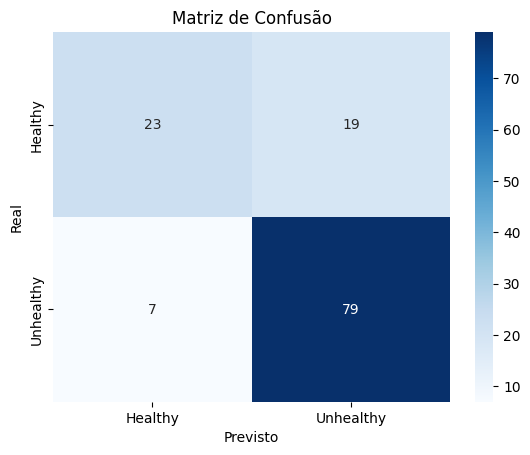

              precision    recall  f1-score   support

     Healthy       0.77      0.55      0.64        42
   Unhealthy       0.81      0.92      0.86        86

    accuracy                           0.80       128
   macro avg       0.79      0.73      0.75       128
weighted avg       0.79      0.80      0.79       128



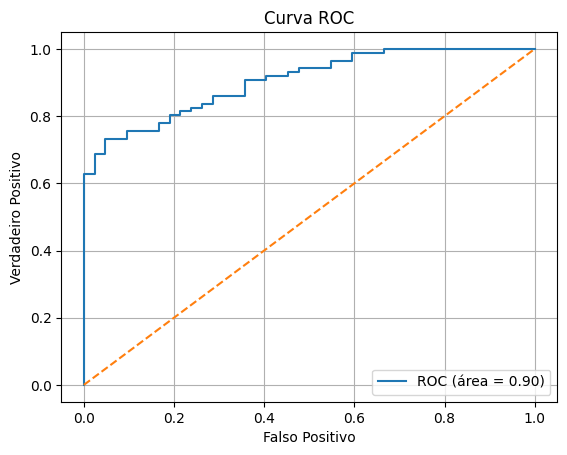

In [13]:
from tensorflow.keras import applications


augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.3),
])


base_model = applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


labels_train = []
for _, label in train_set:
    labels_train.extend(label.numpy())
class_weights = class_weight.compute_class_weight('balanced', classes=tf.unique(labels_train)[0].numpy(), y=labels_train)
class_weights = dict(enumerate(class_weights))


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(train_set, validation_data=val_set, epochs=30, class_weight=class_weights, callbacks=[early_stop])

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

y_true, y_pred, pred_probs = [], [], []
for images, labels in val_set:
    preds = model.predict(images)
    pred_classes = np.argmax(preds, axis=1)
    y_pred.extend(pred_classes)
    y_true.extend(labels.numpy())
    pred_probs.extend(preds[:, 1])

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Unhealthy'], yticklabels=['Healthy', 'Unhealthy'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

print(classification_report(y_true, y_pred, target_names=['Healthy', 'Unhealthy']))

y_true_bin = label_binarize(y_true, classes=[0, 1])
fpr, tpr, _ = roc_curve(y_true_bin, pred_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.legend(loc='lower right')
plt.title('Curva ROC')
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Classificação: Healthy
Confiança: 95.66%


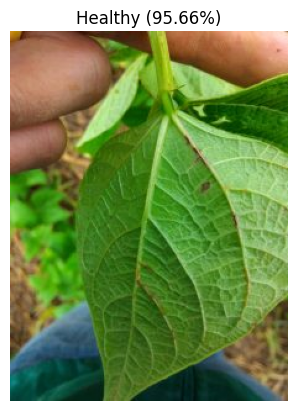

In [ ]:

from tensorflow.keras.utils import load_img, img_to_array

image_path = '/content/drive/MyDrive/teste.jpg'
def prepare_image(img_path, target_size=(224, 224)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    return img_array

img_array = prepare_image(image_path)
pred = model.predict(img_array)
class_names = ['Healthy', 'Unhealthy']
class_index = np.argmax(pred)
confidence = np.max(pred)

print(f'Classificação: {class_names[class_index]}')
print(f'Confiança: {confidence * 100:.2f}%')

plt.imshow(load_img(image_path))
plt.title(f'{class_names[class_index]} ({confidence * 100:.2f}%)')
plt.axis('off')
plt.show()


In [ ]:
!pip install requests

import requests
import json
import pytz
from datetime import datetime


SUPABASE_URL = '...'
SUPABASE_API_KEY = '...'
SUPABASE_TABLE = '...'

acuracia = round(float(confidence * 100), 2)
saudefolha = class_names[class_index]

fuso_brasil = pytz.timezone("America/Sao_Paulo")
data_classificacao = datetime.now(fuso_brasil).strftime("%d/%m/%Y %H:%M")

url = f"{SUPABASE_URL}/rest/v1/{SUPABASE_TABLE}"
headers = {
    "apikey": SUPABASE_API_KEY,
    "Authorization": f"Bearer {SUPABASE_API_KEY}",
    "Content-Type": "application/json",
    "Prefer": "return=representation"
}

payload = {
    "acuracia": acuracia,
    "saudeFolha": saudefolha,
    "date": data_classificacao
}

resposta = requests.post(url, headers=headers, data=json.dumps(payload))

print("Status:", resposta.status_code)
print("Resposta:", resposta.text)

Status: 201
Resposta: [{"acuracia":95.66,"saudeFolha":"Healthy","uuid":"89005679-24fa-4ff0-bee1-111f2cfa4cd7","date":"2025-03-07"}]
